In [1]:
# Activate environment in current folder
using Pkg
Pkg.activate(pwd())


  Activating project at `~/Desktop/School Stuff/Winter 2024/Research/2024-frequency-memory`


In [28]:
# Import packages
using Dates, Plots, DifferentialEquations, LaTeXStrings, Statistics, Measures, Peaks, DelimitedFiles, Roots, QuadGK, SpecialFunctions, Interpolations, BenchmarkTools

In [17]:
function integrate(f, p, u0, times; cb = nothing, transient = 0, int_method = Vern9(), dt = false)
    # Helper function to integrate a system of ode
    
    prob = ODEProblem(f, u0, (times[1], times[end]+transient), p, callback = cb)
    sol = solve(prob, int_method, dt = dt, saveat = times .+ transient)

    return sol
end

function palette_from_hex(hex_list)
    # Function that returns a Julia color palette based on a list of hex codes
    hash_list = [string("#", i) for i in hex_list]
    
    pal = []
    for i in hash_list
        push!(pal, parse(Colorant, i))
    end
    return palette(pal)
end

custom_palette = palette_from_hex(["009afa","e36f47","3ea44d","c371d2","ac8e18", "03aaae","ed5e93","c68225","03a98d","8e971d", "03a9cc","9b7fe9","618df6","f06073","dd65b6", "6c9f33","f61067","f7aef8","72ddf7","5e239d", "80ff72","00afb9","685044","fed9b7","f07167"])

default(
    linewidth = 2, 
    markerstrokewidth = 0,
    palette = palette_from_hex(["009afa","e36f47","3ea44d","c371d2","ac8e18", "03aaae","ed5e93","c68225","03a98d","8e971d", "03a9cc","9b7fe9","618df6","f06073","dd65b6", "6c9f33","f61067","f7aef8","72ddf7","5e239d", "80ff72","00afb9","685044","fed9b7","f07167"])
)

# Plotting formatter
cos_func(x, y) = (x, cos(y))
plt_mod = [(cos_func, 0, 1), (cos_func, 0, 2), 3, (cos_func, 0, 4)];


# coupling function
function coupling_atan(x)
    return atan(8*(1-x))/8 + x
end

# defining some functions to detect the phase differences
function center_phase(x; circ = 2*π)
    mod(x + circ/2, circ) - circ/2
end

function circ_distance(x1, x2; circ = 2*π)
    foo1 =  - center_phase.(x1) + center_phase.(x2)
    foo1 = mod.(foo1 .+ π, 2*π) .- π
end

function cluster_detect(points; max_clusters = 4, thresh = 0.05)
    # Function that takes in a list of complex numbers and figures out how many tight clusters there are

    # iterates over possible cycle lengths and checks if each cycle lengths is of order i
    for i in 1:max_clusters
        sections = points[1:i:end] # list of points with the given cycle as interval

        # check if distance of points from their mean is within treshhold
        mm = mean(sections) # average positions of points
        farthest = maximum(abs.(sections .- mm))    # highest distance between points and their average (a perfect cluster would have this as 0)
        if farthest < thresh
            return i    # if we detect that all the points are close enough to the mean, then we conclude that the system is in this cyclic regime
        end
    end

    return NaN # if we go through all the cycles and none present a cyclic behaviour, then we conclude that they are not entrained
end

cluster_detect (generic function with 1 method)

### Competition test

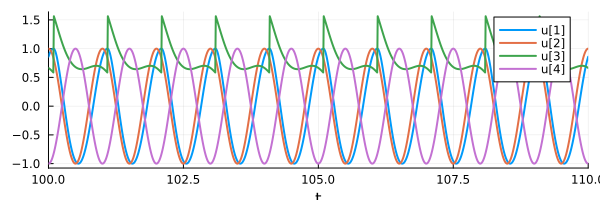

In [67]:
# Define system
function f(du, u, p, t)
    du[1] = coupling_atan(u[3])*2*π + p[2]*sin(u[2] - u[1])
    du[2] = 2*π*p[1]
    du[3] = -p[3]*(u[3]) + p[4]*sin(u[4])*u[3]
    du[4] = 2*π*p[1]
end

# Parameters 
p = [
    1.,    # Frequency
    1.5,    # couping 1
    1.0,    # alpha
    1.5,    # coupling 2
]

# Initial conditions 
u0 = [
    0.0,
    0.0,
    1.1,
    0.0
]
u0[4] = u0[2] + π # pi shift the other entraining oscillator

# Pulse Callback
condition(u,t,integrator) = sin((u[1])/2)
affect!(integrator) = integrator.u[3] += p[3]
cb = ContinuousCallback(condition, affect!, save_positions=(false,false))

# times
times = 0:0.01:10


# get solution
sol = integrate(f, p, u0, times, cb = cb, transient = 100/p[1], int_method = Euler(), dt = 0.001)


plot(sol, idxs = plt_mod, size = (600, 200))

# competition test 

In [32]:
function get_phases(p, u0; thresh = 0.05, plot_traj = true)
    
    # Pulse Callback
    condition(u,t,integrator) = sin((u[1])/2)
    affect!(integrator) = integrator.u[3] += p[3]
    cb = ContinuousCallback(condition, affect!, save_positions=(false,false))


    # Times 
    final_time = 20/p[1]
    times = 0:0.005:final_time

    # Integration
    sol = integrate(f, p, u0, times, transient = 1000/p[1], cb = cb, int_method = Euler(), dt = 0.001)


    # Get the peaks
    phi_peaks = argmaxima(cos.(sol[1, :]))      # index of the peaks for phi
    theta_peaks = argmaxima(cos.(sol[2, :]))    # index of the peaks for thea 

    # Get the position around unit circle
    phi_phases = exp.(-sol[1, theta_peaks]*1im)
    theta_phases = exp.(sol[2, phi_peaks]*1im)



    if plot_traj == true 
        # Plot the trajectories
        plt1 = plot(sol, idxs = plt_mod, title = string("amp: ", p[2], " per: ", 1/p[1]))

        # Plot the unit circle 
        plt2 = plot(exp.((0:2*π*0.01:2*π)*1im), color = :grey, linewidth = 1, label = nothing)
        scatter!(plt2, phi_phases, alpha = 0.5, color = :brown2, label =  L"\phi")
        scatter!(plt2, theta_phases, alpha = 0.5, color = :skyblue, label =  L"\theta")
        
        # Plot the unit circle 
        plt3 = plot(exp.((0:2*π*0.01:2*π)*1im), color = :grey, linewidth = 1, title = L"\theta")
        scatter!(plt3, theta_phases, alpha = 0.5, color = :skyblue)


        l = @layout [a ; a]

        plot(plt1, plt2,  layout = l, aspect_ratio = 1.0)

        savefig(string("test_figs/", "test", ".png"))
        savefig(string("test_figs/", now(), ".png"))
    end

    return phi_phases, theta_phases
end


get_phases(
    [
        1.,    # Frequency
        1.5,    # couping 1
        1,    # alpha
        1.5,    # coupling 2
    ], 
    [
        0.0,
        0.0,
        1.1,
        0.0 + π
    ]
    )

(ComplexF64[0.859121625209743 + 0.511771465692422im, 0.859121625406037 + 0.5117714653628992im, 0.8591216256018654 + 0.5117714650341577im, 0.8591216257972285 + 0.5117714647061977im, 0.859121625993057 + 0.5117714643774562im, 0.8591216261888854 + 0.5117714640487148im, 0.859121626384714 + 0.5117714637199733im, 0.8591216265800771 + 0.5117714633920132im, 0.85912162677544 + 0.5117714630640531im, 0.859121626971734 + 0.5117714627345303im, 0.8591216271675625 + 0.5117714624057889im, 0.8591216273629255 + 0.5117714620778288im, 0.8591216275592195 + 0.5117714617483059im, 0.8591216277545826 + 0.5117714614203458im, 0.859121627950411 + 0.5117714610916043im, 0.8591216281462395 + 0.5117714607628628im, 0.8591216283425335 + 0.5117714604333401im, 0.8591216285374311 + 0.5117714601061614im, 0.8591216287332596 + 0.5117714597774199im], ComplexF64[0.8270804965420605 + 0.5620834922320158im, 0.8270804963126662 + 0.5620834925695591im, 0.8270804960837832 + 0.5620834929063502im, 0.827080495854389 + 0.5620834932438935i

In [68]:
amps1 = LinRange(0, 1.0, 40)
amps2 = LinRange(0, 1.5, 40)
entrain_grid = fill(NaN, size(amps1)..., size(amps2)...)

for (j, amp1) in enumerate(amps1)
    for (i, amp2) in enumerate(amps2)
        phases = get_phases(
            [   # Parameters
                1.2,    # Frequency
                amp1,    # coupling 1
                1.0,    #alpha
                amp2,    # coupling 2
            ],
            [
                0.0, # phi
                0.0, # theta 1
                1.1, # x 
                0.0 + π, # theta 2
            ]
        )[1]
        if cluster_detect(phases) == 1
            entrain_grid[j, i] = angle(phases[end])
        end
    end
end

In [1]:
plt1 = plot(xlabel = L"k_1", ylabel = L"k_2", grid = false)
heatmap!(plt1, amps1, amps2, transpose(entrain_grid), color = :dense)


LoadError: LoadError: UndefVarError: `@L_str` not defined
in expression starting at /Users/christiandenis/Desktop/School Stuff/Winter 2024/Research/2024-frequency-memory/competition.ipynb:1